In [14]:
import torch

import networkx as nx

import numpy as np
    
import pandas as pd

import scipy.io

from itertools import combinations as comb

from tqdm.notebook import tqdm

import pickle

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import f1_score

from numpy.linalg import pinv

# Clean Tensor from Separate Data
Using Tensor constructed from separate data without anomaly injections

In [2]:
bc_data = scipy.io.loadmat("datasets/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(str(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

Graph with 5196 nodes and 172897 edges


Text(0, 0.5, 'Frequency')

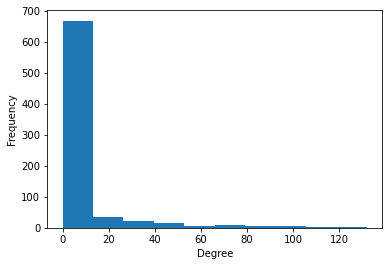

In [3]:
plt.hist(nx.degree_histogram(G))
plt.xlabel('Degree')
plt.ylabel('Frequency')

In [4]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs = []

    max_graph = 0

    for i in tqdm(range(G.number_of_nodes())):
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)
            if max_graph < G_ego.number_of_nodes():
                max_graph = G_ego.number_of_nodes()

    return G, ego_gs, max_graph

In [5]:
G, ego_gs, _ = load_bc_data(G)

  0%|          | 0/5196 [00:00<?, ?it/s]

In [6]:
# get anomalous egonets
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [7]:
anom_gs, clean_gs = [], []
for idx, g in enumerate(tqdm(ego_gs, total=len(ego_gs))):
    # check if root is anomolous first
    if is_anomolous(g):
        anom_gs.append(g)
    else:
        clean_gs.append(g)

print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 4720/5196
# of clean graphs: 476/5196


In [8]:
with open('decomp.sav', 'rb') as f:
    result = pickle.load(f)
    f.close()

In [9]:
core, factors = result

In [10]:
A, B, C = factors

In [11]:
A, B, C, = np.array(A), np.array(B), np.array(C)

In [12]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

  0%|          | 0/4720 [00:00<?, ?it/s]

In [13]:
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/476 [00:00<?, ?it/s]

In [14]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

  0%|          | 0/4720 [00:00<?, ?it/s]

In [15]:
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

  0%|          | 0/476 [00:00<?, ?it/s]

In [16]:
print(max(results_anom), min(results_anom))
print(max(results_clean), min(results_clean))

151.99378506962825 5.922384155613057
28.182793853936584 3.138077086574925


In [17]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

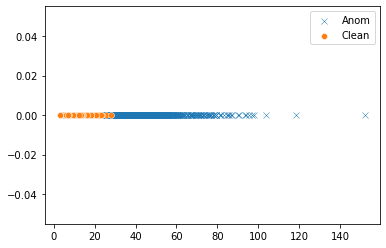

In [18]:
sns.scatterplot(x=results_anom, y=anom_y, marker='x')
sns.scatterplot(x=results_clean, y=clean_y, marker='o')

plt.legend(['Anom', 'Clean'])

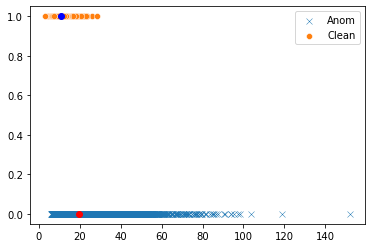

In [20]:
sns.scatterplot(x=results_anom, y=[0] * len(anom_y), marker='x')
sns.scatterplot(x=results_clean, y=[1] * len(clean_y), marker='o')
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 1, c='blue')

plt.legend(['Anom', 'Clean'])

In [ ]:
sns.histplot(results_anom)
sns.histplot(results_clean, ax=plt.gca())

In [ ]:
comb = [results_clean, results_anom]

In [ ]:
plt.boxplot(comb)

In [ ]:
# using non-anomolous nodes from original data (no anomalies)

with open('egonets.sav', 'rb') as f:
    ego_gs = pickle.load(f)
    f.close()

print(f'Using {len(ego_gs)} egonets')

In [ ]:
indices = np.random.randint(0, len(anom_gs), size=len(clean_gs))

sampled_anoms = np.array(anom_gs, dtype=object)[indices]

In [ ]:
padded_anom = []
for gs in tqdm(sampled_anoms):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

In [ ]:
results_anom = []
indices = np.random.randint(0, len(padded_anom), size=len(padded_clean))
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

In [ ]:
anom_y = np.zeros(len(results_anom))

In [ ]:
sns.scatterplot(x=results_anom, y=anom_y, marker='x')
sns.scatterplot(x=results_clean, y=clean_y, marker='o')

plt.legend(['Anom', 'Clean'])

## Redefine Anomalies
Redefining anomalies egonets as egonets with root node as anomalous

In [ ]:
bc_data = scipy.io.loadmat("datasets/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(str(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

In [ ]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []
    max_graph = 0

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)

    return G, ego_gs, max_graph, roots

In [ ]:
G, ego_gs, _, roots = load_bc_data(G)

In [ ]:
roots = [int(r) for r in roots]

In [ ]:
anom_gs, clean_gs = [], []
for idx, root_attr in enumerate(tqdm(roots)):
    if root_attr == 1:
        anom_gs.append(ego_gs[idx])
    else:
        clean_gs.append(ego_gs[idx])
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

In [ ]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

In [ ]:
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

In [ ]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

In [ ]:
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

In [ ]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

In [ ]:
sns.scatterplot(x=results_clean, y=clean_y, marker='o')
sns.scatterplot(x=results_anom, y=anom_y, marker='x')

plt.legend(['Anom', 'Clean'])

In [ ]:
sns.histplot(results_anom)
sns.histplot(results_clean, ax=plt.gca())

In [ ]:
comb = [results_clean, results_anom]
plt.boxplot(comb)

# Clean tensor with modified data
Using "clean" tensor from redefined clean egonets. 

See BC_EgoNet_Tensor.ipynb for details. 

In [5]:
with open('bc_decomp_r10.sav', 'rb') as f:
    result = pickle.load(f)
    f.close()
    
core, factors = result
A, B, C = factors
A, B, C, = np.array(A), np.array(B), np.array(C)

## Original Anomaly Definition

In [6]:
bc_data = scipy.io.loadmat("datasets/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(str(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

Graph with 5196 nodes and 172897 edges


In [7]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs = []

    max_graph = 0

    for i in tqdm(range(G.number_of_nodes())):
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)
            if max_graph < G_ego.number_of_nodes():
                max_graph = G_ego.number_of_nodes()

    return G, ego_gs, max_graph

In [8]:
G, ego_gs, _ = load_bc_data(G)

  0%|          | 0/5196 [00:00<?, ?it/s]

In [9]:
# get anomalous egonets
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [11]:
anom_gs, clean_gs = [], []
for idx, g in enumerate(tqdm(ego_gs, total=len(ego_gs))):
    # check if root is anomolous first
    if is_anomolous(g):
        anom_gs.append(g)
    else:
        clean_gs.append(g)

print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 4720/5196
# of clean graphs: 476/5196


In [12]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

  0%|          | 0/4720 [00:00<?, ?it/s]

In [13]:
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/476 [00:00<?, ?it/s]

In [14]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

  0%|          | 0/4720 [00:00<?, ?it/s]

In [15]:
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

  0%|          | 0/476 [00:00<?, ?it/s]

In [32]:
# storing results
saved_model = open('rec_error_clean.sav', 'wb')
pickle.dump(results_clean, saved_model)
saved_model.close()

saved_model = open('rec_error_anom.sav', 'wb')
pickle.dump(results_anom, saved_model)
saved_model.close()

In [33]:
print(max(results_anom), min(results_anom))
print(max(results_clean), min(results_clean))

150.97796461553804 4.725902221549903
29.628322688595038 3.0777879545964697


In [16]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

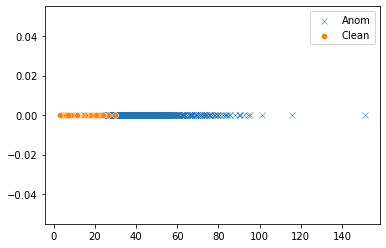

In [17]:
sns.scatterplot(x=results_anom, y=anom_y, marker='x')
sns.scatterplot(x=results_clean, y=clean_y, marker='o')

plt.legend(['Anom', 'Clean'])

<AxesSubplot:ylabel='Count'>

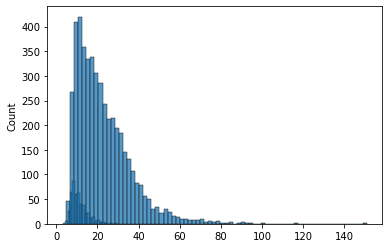

In [18]:
sns.histplot(results_anom)
sns.histplot(results_clean, ax=plt.gca())

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb59c532d00>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb59c52a3a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb59c540910>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb59c52a880>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb59c52ab50>,
 'means': []}

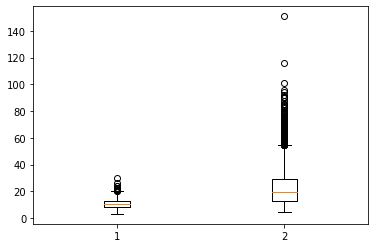

In [19]:
comb = [results_clean, results_anom]
plt.boxplot(comb)

# 2-means clustering

In [2]:
with open('rec_error_clean.sav', 'rb') as f:
    results_clean = pickle.load(f)
    f.close()
    
with open('rec_error_anom.sav', 'rb') as f:
    results_anom = pickle.load(f)
    f.close()

In [3]:
results, true_labels = [], []
results.extend(results_clean); results.extend(results_anom)
true_labels.extend([0] * len(results_clean)); true_labels.extend([1] * len(results_anom))

In [4]:
results = np.array(results).reshape(-1, 1)

In [5]:
kmeans = KMeans(n_clusters=2, random_state=1).fit(results)

<AxesSubplot:>

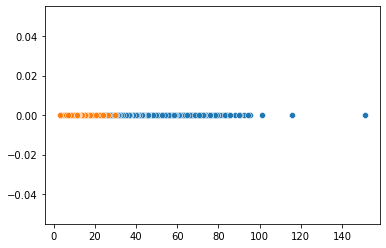

In [6]:
sns.scatterplot(x=results_anom, y=np.zeros(len(results_anom)))
sns.scatterplot(x=results_clean, y=np.zeros(len(results_clean)))

<AxesSubplot:>

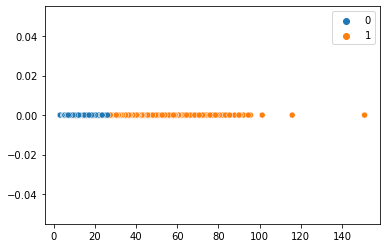

In [7]:
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=kmeans.labels_)

In [8]:
# F1 score

print(np.unique(true_labels, return_counts=True))
print(np.unique(kmeans.labels_, return_counts=True))

print(f1_score(true_labels, kmeans.labels_))

(array([0, 1]), array([ 476, 4720]))
(array([0, 1], dtype=int32), array([3729, 1467]))
0.47389688055600454


## GMM

In [9]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)

gmm.fit(results)

GaussianMixture(n_components=2)

In [10]:
labels = gmm.predict(results)

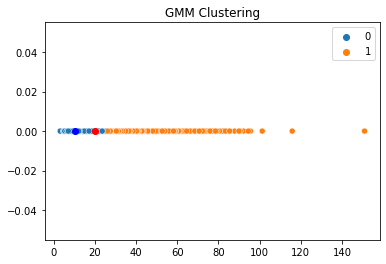

In [11]:
plt.title('GMM Clustering')
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=labels)
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 0, c='blue')

In [12]:
# F1 score

print(np.unique(true_labels, return_counts=True))
print(np.unique(labels, return_counts=True))

print(f1_score(true_labels, labels))

(array([0, 1]), array([ 476, 4720]))
(array([0, 1]), array([3637, 1559]))
0.4959388437649307


## Redefined Anomalies

In [13]:
bc_data = scipy.io.loadmat("datasets/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(str(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

Graph with 5196 nodes and 172897 edges


In [14]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)

    return G, ego_gs, roots

In [15]:
G, ego_gs, roots = load_bc_data(G)

  0%|          | 0/5196 [00:00<?, ?it/s]

In [16]:
roots = [int(r) for r in roots]

In [17]:
anom_gs, clean_gs = [], []
for idx, root_attr in enumerate(tqdm(roots)):
    if root_attr == 1:
        anom_gs.append(ego_gs[idx])
    else:
        clean_gs.append(ego_gs[idx])
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 298/5196
# of clean graphs: 4898/5196


In [18]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

  0%|          | 0/298 [00:00<?, ?it/s]

In [19]:
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/4898 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

In [ ]:
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

In [58]:
# storing results
saved_model = open('rec_error_clean_mod.sav', 'wb')
pickle.dump(results_clean, saved_model)
saved_model.close()

saved_model = open('rec_error_anom_mod.sav', 'wb')
pickle.dump(results_anom, saved_model)
saved_model.close()

In [59]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

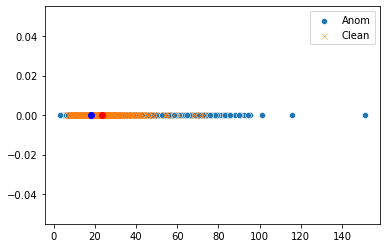

In [60]:
sns.scatterplot(x=results_clean, y=clean_y, marker='o')
sns.scatterplot(x=results_anom, y=anom_y, marker='x')
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 0, c='blue')

plt.legend(['Anom', 'Clean'])

<AxesSubplot:ylabel='Count'>

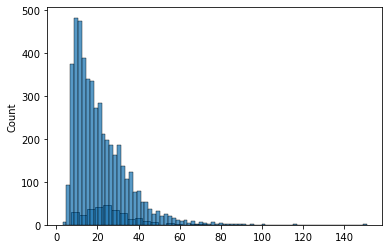

In [61]:
sns.histplot(results_anom)
sns.histplot(results_clean, ax=plt.gca())

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9d47ef0130>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9d47ef0760>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9d47ef0c40>,
 'medians': [<matplotlib.lines.Line2D at 0x7f9d47ef0d90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa16b81e3a0>,
 'means': []}

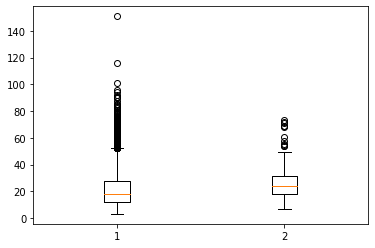

In [62]:
comb = [results_clean, results_anom]
plt.boxplot(comb)

# 2-means clustering

In [20]:
with open('rec_error_clean_mod.sav', 'rb') as f:
    results_clean = pickle.load(f)
    f.close()
    
with open('rec_error_anom_mod.sav', 'rb') as f:
    results_anom = pickle.load(f)
    f.close()

In [22]:
results, true_labels = [], []
results.extend(results_clean); results.extend(results_anom)
true_labels.extend([0] * len(results_clean)); true_labels.extend([1] * len(results_anom))

In [23]:
results = np.array(results).reshape(-1, 1)

In [24]:
kmeans = KMeans(n_clusters=2, random_state=1).fit(results)

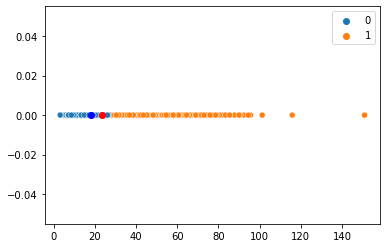

In [25]:
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=kmeans.labels_)
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 0, c='blue')

In [26]:
# F1 score

print(np.unique(true_labels, return_counts=True))
print(np.unique(kmeans.labels_, return_counts=True))

print(f1_score(true_labels, kmeans.labels_))

(array([0, 1]), array([4898,  298]))
(array([0, 1], dtype=int32), array([3719, 1477]))
0.13183098591549294


## GMM

In [27]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)

gmm.fit(results)

GaussianMixture(n_components=2)

In [28]:
labels = gmm.predict(results)

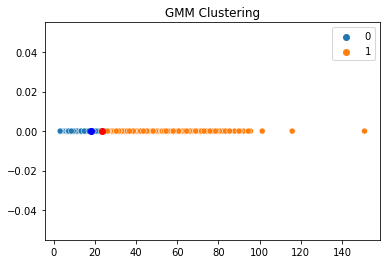

In [29]:
plt.title('GMM Clustering')
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=labels)
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 0, c='blue')

In [30]:
# F1 score

print(np.unique(true_labels, return_counts=True))
print(np.unique(labels, return_counts=True))

print(f1_score(true_labels, labels))

(array([0, 1]), array([4898,  298]))
(array([0, 1]), array([3663, 1533]))
0.1354451119606772


# Comparing rank

In [6]:
bc_data = scipy.io.loadmat("datasets/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(str(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

Graph with 5196 nodes and 172897 edges


In [10]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []
    max_graph = 0

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)

    return G, ego_gs, max_graph, roots

# get anomalous egonets
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [8]:
G, ego_gs, _, roots = load_bc_data(G)

roots = [int(r) for r in roots]

  0%|          | 0/5196 [00:00<?, ?it/s]

In [11]:
anom_gs, clean_gs = [], []
for idx, g in enumerate(tqdm(ego_gs, total=len(ego_gs))):
    if is_anomolous(g):
        anom_gs.append(g)
    else:
        clean_gs.append(g)

print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 4720/5196
# of clean graphs: 476/5196


In [12]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

In [29]:
with open('decomp_rank_10.sav', 'rb') as f:
    result = pickle.load(f)
    f.close()
    
core, factors = result
A, B, C = factors
A, B, C, = np.array(A), np.array(B), np.array(C)

In [30]:
results_anom_rank10 = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom_rank10.append(d)
    
results_clean_rank10 = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean_rank10.append(d)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

In [31]:
with open('decomp_rank_20.sav', 'rb') as f:
    result = pickle.load(f)
    f.close()
    
core, factors = result
A, B, C = factors
A, B, C, = np.array(A), np.array(B), np.array(C)

In [32]:
results_anom_rank20 = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom_rank20.append(d)
    
results_clean_rank20 = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean_rank20.append(d)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

In [33]:
with open('decomp_rank_30.sav', 'rb') as f:
    result = pickle.load(f)
    f.close()
    
core, factors = result
A, B, C = factors
A, B, C, = np.array(A), np.array(B), np.array(C)

In [34]:
results_anom_rank30 = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom_rank30.append(d)
    
results_clean_rank30 = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean_rank30.append(d)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

In [73]:
np.median(results_anom_rank10)

19.77976919352111

Medians (Anom): 
	Rank 10: 19.77976919352111 
	Rank 20: 19.29826500033036 
	Rank 30: 18.804974818125746
Medians (Clean): 
	Rank 10: 10.158757345814799 
	Rank 20: 9.839839314037569 
	Rank 30: 9.434414607191169


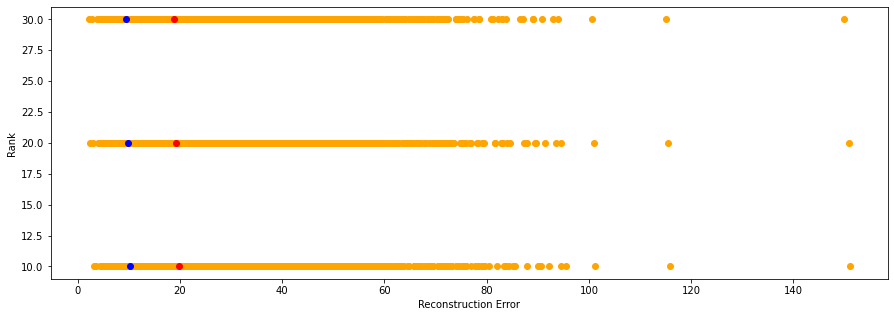

In [107]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
y_len = len(ego_gs)

plt.scatter(x=np.concatenate((results_anom_rank10, results_clean_rank10)), y=np.ones(y_len)*10, c='orange')
plt.scatter([np.median(results_anom_rank10)], 10, c='red')
plt.scatter([np.median(results_clean_rank10)], 10, c='blue')

plt.scatter(x=np.concatenate((results_anom_rank20, results_clean_rank20)), y=np.ones(y_len)*20, c='orange')
plt.scatter([np.median(results_anom_rank20)], 20, c='red')
plt.scatter([np.median(results_clean_rank20)], 20, c='blue')

plt.scatter(x=np.concatenate((results_anom_rank30, results_clean_rank30)), y=np.ones(y_len)*30, c='orange')
plt.scatter([np.median(results_anom_rank30)], 30, c='red')
plt.scatter([np.median(results_clean_rank30)], 30, c='blue')

# plt.legend(['Anom', 'Clean'])

plt.ylabel('Rank')
plt.xlabel('Reconstruction Error')

print("Medians (Anom):", '\n\tRank 10:', np.median(results_anom_rank10), '\n\tRank 20:', np.median(results_anom_rank20), '\n\tRank 30:', np.median(results_anom_rank30))
print("Medians (Clean):", '\n\tRank 10:', np.median(results_clean_rank10), '\n\tRank 20:', np.median(results_clean_rank20), '\n\tRank 30:', np.median(results_clean_rank30))

Means (Anom): 
	Rank 10: 22.8006186111722 
	Rank 20: 22.256011199588613 
	Rank 30: 21.708269331215998
Means (Clean): 
	Rank 10: 11.016616284701675 
	Rank 20: 10.612503572572765 
	Rank 30: 10.251006571134413


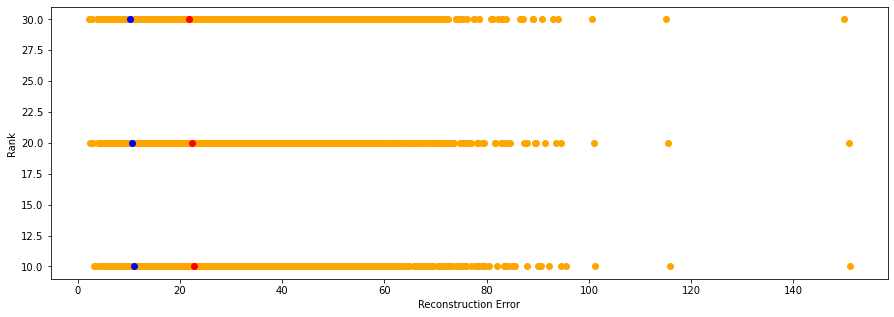

In [108]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
y_len = len(ego_gs)

plt.scatter(x=np.concatenate((results_anom_rank10, results_clean_rank10)), y=np.ones(y_len)*10, c='orange')
plt.scatter([np.mean(results_anom_rank10)], 10, c='red')
plt.scatter([np.mean(results_clean_rank10)], 10, c='blue')

plt.scatter(x=np.concatenate((results_anom_rank20, results_clean_rank20)), y=np.ones(y_len)*20, c='orange')
plt.scatter([np.mean(results_anom_rank20)], 20, c='red')
plt.scatter([np.mean(results_clean_rank20)], 20, c='blue')

plt.scatter(x=np.concatenate((results_anom_rank30, results_clean_rank30)), y=np.ones(y_len)*30, c='orange')
plt.scatter([np.mean(results_anom_rank30)], 30, c='red')
plt.scatter([np.mean(results_clean_rank30)], 30, c='blue')

# plt.legend(['Anom', 'Clean'])

plt.ylabel('Rank')
plt.xlabel('Reconstruction Error')

print("Means (Anom):", '\n\tRank 10:', np.mean(results_anom_rank10), '\n\tRank 20:', np.mean(results_anom_rank20), '\n\tRank 30:', np.mean(results_anom_rank30))
print("Means (Clean):", '\n\tRank 10:', np.mean(results_clean_rank10), '\n\tRank 20:', np.mean(results_clean_rank20), '\n\tRank 30:', np.mean(results_clean_rank30))

# Testing on different data

In [7]:
def load_network(path):
    
    try:
        data = scipy.io.loadmat(path)
    except:
        print('Invalid data path')

    G = nx.from_scipy_sparse_array(data["Network"])
    # nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
    print(str(G))

    # convert list of lists to list
    labels = [j for i in data["Label"] for j in i]

    # Add labels to each node
    for i in range(len(G.nodes)):
        G.nodes[i]['Anomaly'] = labels[i]

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)

    return G, ego_gs, roots

In [ ]:
G, ego_gs, roots = load_network('datasets/Flickr.mat')

roots = [int(r) for r in roots]

In [4]:
print(f'Using {len(ego_gs)} egonets')

Using 16445 egonets


In [5]:
# get anomalous egonets for definition 2
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [6]:
anom_gs, clean_gs = [], []
for idx, g in enumerate(tqdm(ego_gs)):
    # check if root is anomolous first
    if is_anomolous(g):
        anom_gs.append(g)
    else:
        clean_gs.append(g)
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/16445 [00:00<?, ?it/s]

# of anomalous graphs: 4633/16445
# of clean graphs: 11812/16445


In [8]:
slice_size = int(input("Input a slice size for tensor: "))

cube = torch.empty((1, slice_size, slice_size, slice_size))

for i in tqdm(range(len(clean_gs[:slice_size]))):
    slice_gs = nx.to_numpy_array(clean_gs[i])[:slice_size, :slice_size]
    result = np.zeros((slice_size, slice_size))
    result[:slice_gs.shape[0],:slice_gs.shape[1]] = slice_gs
    
    ten = torch.as_tensor(result)
    dim = ten.shape[0]
    cube[0, :dim, :dim, i] = ten

Input a slice size for tensor: 1000


  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
saved_model = open('acm_tens.sav', 'wb')
pickle.dump(cube, saved_model)
saved_model.close()

In [10]:
with open('acm_tens.sav', 'rb') as f:
    cube = pickle.load(f)
    f.close()

In [ ]:
# padding adjacency matrices
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)
    
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/4633 [00:00<?, ?it/s]

  0%|          | 0/11812 [00:00<?, ?it/s]

# CP Decomposition

In [3]:
with open('cp_decomp_mod.sav', 'rb') as f:
    result = pickle.load(f)
    f.close()
    
core, factors = result
A, B, C = factors
A, B, C, = np.array(A), np.array(B), np.array(C)

In [4]:
# get anomalous egonets for definition 2
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [8]:
G, ego_gs, roots = load_network('datasets/Blogcatalog.mat')

roots = [int(r) for r in roots]

Graph with 5196 nodes and 172897 edges


  0%|          | 0/5196 [00:00<?, ?it/s]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [10]:
anom_gs, clean_gs = [], []
for idx, g in enumerate(tqdm(ego_gs)):
    # check if root is anomolous first
    if is_anomolous(g):
        anom_gs.append(g)
    else:
        clean_gs.append(g)
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 4720/5196
# of clean graphs: 476/5196


In [12]:
# padding adjacency matrices
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)
    
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

In [15]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((pinv(A) @ gs) @ B) @ pinv(B))
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)
    
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((pinv(A) @ gs) @ B) @ pinv(B))
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

In [24]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

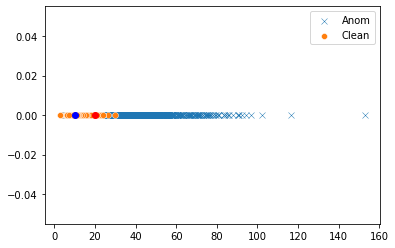

In [26]:
sns.scatterplot(x=results_anom, y=anom_y, marker='x')
sns.scatterplot(x=results_clean, y=clean_y, marker='o')
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 0, c='blue')

plt.legend(['Anom', 'Clean'])